# ProstateX Classification (CNN)

Following notebook presents training on small CNN network for example purposes.

## Import packages

In [1]:
%load_ext autoreload
%matplotlib inline  
import sys
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Import local packages

In [2]:
rel = "../"
sys.path.append(rel+'src')
sys.path.append(rel+'lib')
import prostatex.dataset
import prostatex.model
from prostatex.preprocessing import get_roi, pad_zero
from prostatex.classification import train_test_split
print ("PACKAGES LOADED")

PACKAGES LOADED


## Specify parameters

Following is using trail dataset (only ten ProstateX) patients. To download rest of the cases check the challenge's website (http://spiechallenges.cloudapp.net/competitions/6).

To prepare the train/test dataset follow the file / directory naming convention. 

File:
 - lesion-information/ProstateX.csv

is automatically generated 

In [3]:
# Dataset directory (trail)
dataset_dir = rel+"data/ProstateX/trail"

# ROI (region of interest) width and depth in mm
roi_width_mm=30
roi_depth_mm=9

#Data configuration
train_to_test_ratio = 0.7  #70% = Training Data, 30% = Test Data


#CNN configuration
conv3d_kernel = [6, 6, 3] #Kernel (6,6,3) because voxel size is (1.5,1.5,3)
strides=[1, 1, 1, 1, 1] #Conv3d strides
max_pool3d_ksize = [1, 2, 2, 2, 1] 
max_pool3d_strides = [1, 2, 2, 2, 1]

### Show available tensorflow devices

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2684786633999800209
]


In [5]:
#Tensorflow configuration
device_type = "/cpu:0"

## Create dataset for data manipulation

In [6]:
dataset = prostatex.dataset.DataSet(dataset_dir)
data = dataset.data_aslist()

## Define some helper functions for data batch generation 

In [7]:
from numpy import reshape
from numpy import take
from functools import reduce

'''
Return biggest shape from supplied by volume
'''
def get_biggest_shape(shapes):
    # print('get_biggest_shape',shapes)
    biggest_shape = None
    biggest_shape_volume = None
    for shape in shapes:
        shape_volume = int(reduce(lambda x, y: x*y,shape)) 
        if biggest_shape is None or biggest_shape_volume < shape_volume:
            biggest_shape = shape
            biggest_shape_volume = shape_volume
    # print('get_biggest_shape, out: ',biggest_shape)
    return biggest_shape

'''
Get data (features/image) for model
Given that current method uses 3 modalities, output will be 4 dimentional [x,y,z,m] - where:
- x,y are widht/height corresponding to i and j 
- z is depth corresponding to k
- m is index of modality

To match the dimensions between modalities, data is zero-padded to the biggest shape
'''  
def get_model_x(model,roi_width_mm,roi_depth_mm):
    #Get region of interest of three modalities
    model_roi_ktrans = get_roi(model,'ktrans',roi_width_mm,roi_depth_mm)
    model_roi_dwiadc = get_roi(model,'dwi-adc',roi_width_mm,roi_depth_mm)
    model_roi_t2tra = get_roi(model,'t2-tra',roi_width_mm,roi_depth_mm)
    biggest_shape = get_biggest_shape([model_roi_ktrans.shape,model_roi_dwiadc.shape,model_roi_t2tra.shape])
    target_shape = biggest_shape
    model_roi_ktrans = pad_zero(model_roi_ktrans,target_shape)
    model_roi_dwiadc = pad_zero(model_roi_dwiadc,target_shape)
    model_roi_t2tra = pad_zero(model_roi_t2tra,target_shape)
    model_x = np.zeros([*target_shape,3])
    model_x[:,:,:,0] = model_roi_ktrans
    model_x[:,:,:,1] = model_roi_dwiadc
    model_x[:,:,:,2] = model_roi_t2tra
    return model_x
    
# Return one hot representation given possible_values
def one_hot(value, possible_values):
    return np.eye(len(possible_values))[value]

'''
Get batch from the data
Given that current method uses 3 modalities

X output will be 5 dimentional [i,x,y,z,m] - where:
- x,y are widht/height corresponding to i and j 
- z is the depth corresponding to k
- m is the index of modality
- i is the index of the single model features

Y output (labels) is 2 dimentional because currently network uses one-hot representation for true/false labels (to be corrected)
'''  
def get_batch(data,batch_len,batch_num,roi_width_mm,roi_depth_mm):
    batch_num  = int(batch_num % (len(data)/batch_len))
    start = max(0,batch_len*batch_num)
    end = min(len(data),start+batch_len)
    batch = data[start:end]
    significance_values = [True,False]
    n_values = len(significance_values)
    x = None 
    y = np.zeros([len(batch),len(significance_values)])
    for i in range(len(batch)):
        model =batch[i]
        try:
            model_x = get_model_x(model,roi_width_mm,roi_depth_mm)
            if x is None:
                x = np.zeros([len(batch),*model_x.shape])
            else:
                model_x = pad_zero(model_x,[*x.shape[1:]])
            x[i,:,:,:,:] = model_x
            y[i,:] = one_hot(int(model.clinical_features().significance()),significance_values)
        except ValueError as e:
            print('Could not assign value',e, model)
        except KeyError as e:
            print('Could not find modality',e, model)
    return x, y

'''
Return batch data and labels from data 
'''
def get_batch_xy(data_x,data_y,batch_len,batch_num):
    data_len = len(data_x)
    indexes = range(data_len)
    batch_num  = int(batch_num % (len(data)/batch_len))
    start = max(0,batch_len*batch_num)
    end = min(len(data),start+batch_len)
    indexes = indexes[start:end]
    x = take(data_x,indexes,0)
    y = take(data_y,indexes,0)
    return x,y
    
'''
Get data and labels for all entries in data
'''
def get_xy(data,roi_width_mm,roi_depth_mm):
    return get_batch(data,len(data),0,roi_width_mm,roi_depth_mm)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math


def plot_all(imgdata):
    my_dpi = 96
    w,h=imgdata[0].shape
    columns = rows = math.ceil(math.sqrt(len(imgdata)))
    fig=plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    for i in range(len(imgdata)):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgdata[i])
    plt.show()
    
    
def get_roi_data(data, modality):
    return [get_roi(data,modality,roi_width_mm,0) for data in data if modality in data.images]

def plot_all_transform(data,modality,transformation):
    return plot_all([transformation(roi) for roi in get_roi_data(data,modality)])
    

In [9]:
def norm(data):
    return data/data.max()

## Load train and test data

Note that errors in output indicate dataset errors - differing available modalities, dimensions etc. 
Current CNN require constant dimensions - mismatching data is discarded.

Data is shuffled before split

In [10]:
train_data, test_data = train_test_split(data,train_to_test_ratio)
train_x, train_y = get_xy(train_data,roi_width_mm,roi_depth_mm)
test_x, test_y = get_xy(test_data,roi_width_mm,roi_depth_mm)

Could not assign value [(20, 20), (20, 20), (-1, -1)] cannot contain negative values. <prostatex.model.ProstatexModel object at 0x0000017E2B55ADA0>
Could not find modality 'ktrans' <prostatex.model.ProstatexModel object at 0x0000017E2B55ACC0>


## Display ROIs for one case 

In [11]:
clinsig_data = [x for x in data if x.clinical_features().significance()] 
not_clinsig_data = [x for x in data if not x.clinical_features().significance()] 

print('Len clinsig:',len(clinsig_data))
print('Len not clinsig:',len(not_clinsig_data))
display_test_model = clinsig_data[0]

print('Id:',display_test_model.id())
print('Clinical significance:',display_test_model.clinical_features().significance())

Len clinsig: 4
Len not clinsig: 11
Id: ProstateX-0005
Clinical significance: True


### Ktrans CLINSIG

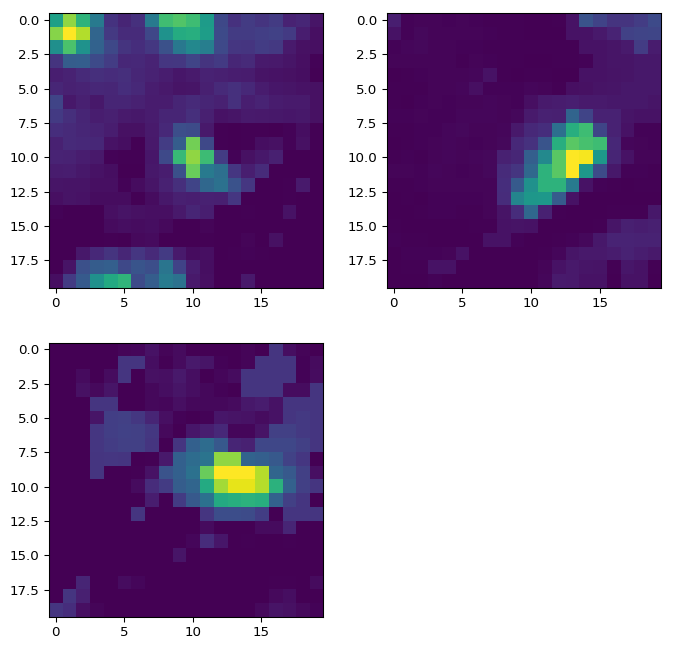

In [12]:
plot_all(get_roi_data(clinsig_data,'ktrans'))

### Ktrans NOTCLINSIG

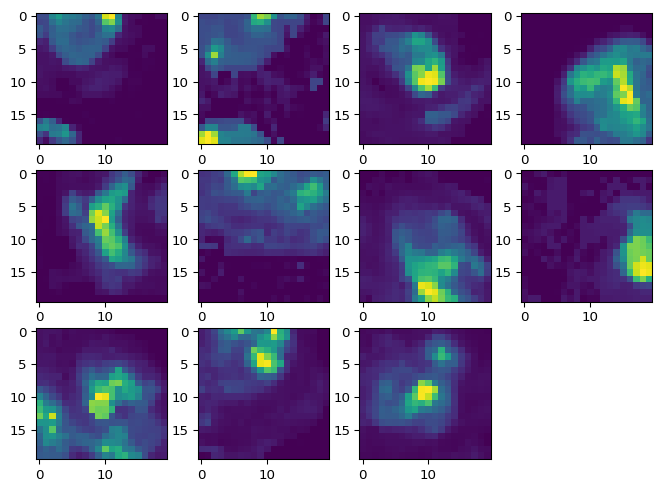

In [13]:
plot_all(get_roi_data(not_clinsig_data,'ktrans'))

### DWI-ADC CLINSIG

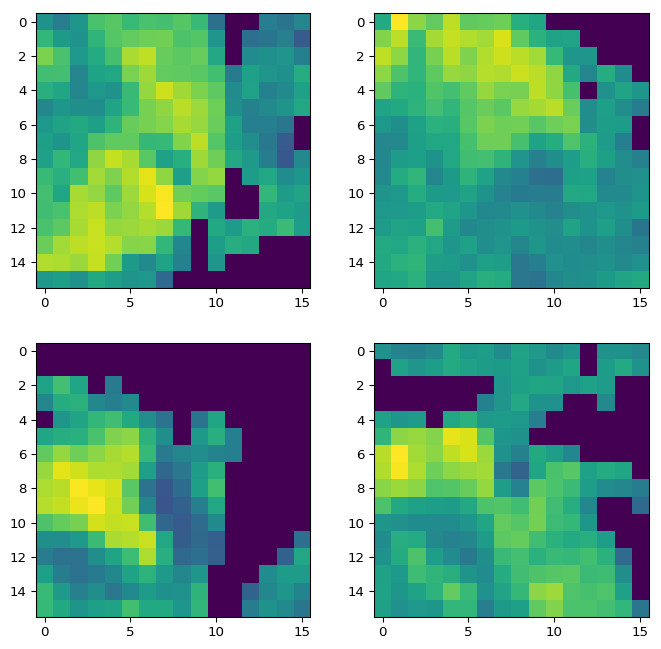

In [14]:
plot_all(get_roi_data(clinsig_data,'dwi-adc'))

### DWI-ADC NOT CLINSIG

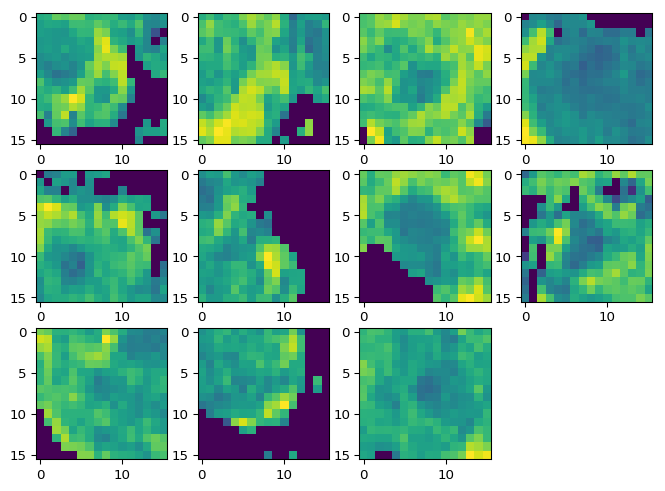

In [15]:
plot_all(get_roi_data(not_clinsig_data,'dwi-adc'))

### T2-TRA CLINSIG

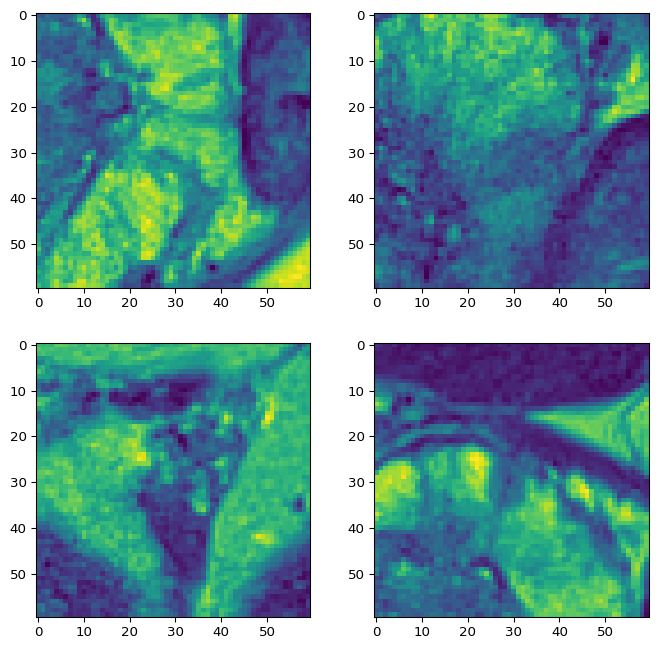

In [16]:
plot_all(get_roi_data(clinsig_data,'t2-tra'))

### T2-TRA NOT CLINSIG

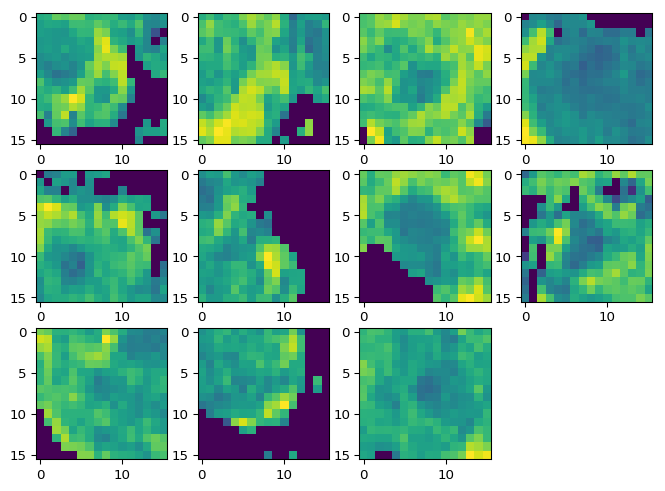

In [17]:
plot_all(get_roi_data(not_clinsig_data,'dwi-adc'))

In [18]:
import scipy.signal as sig

### MEDFILT

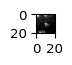

In [19]:
import SimpleITK 

def sitk_show(img, title=None, margin=0.05, dpi=96 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    if title:
        plt.title(title)
    plt.show()

clinsig_ktrans_roi = get_roi_data(clinsig_data,'ktrans')


img = SimpleITK.GetImageFromArray(clinsig_ktrans_roi[0])

imgSmooth = SimpleITK.CurvatureFlow(image1=img,
                                    timeStep=0.125,
                                    numberOfIterations=5)
sitk_show(imgSmooth)

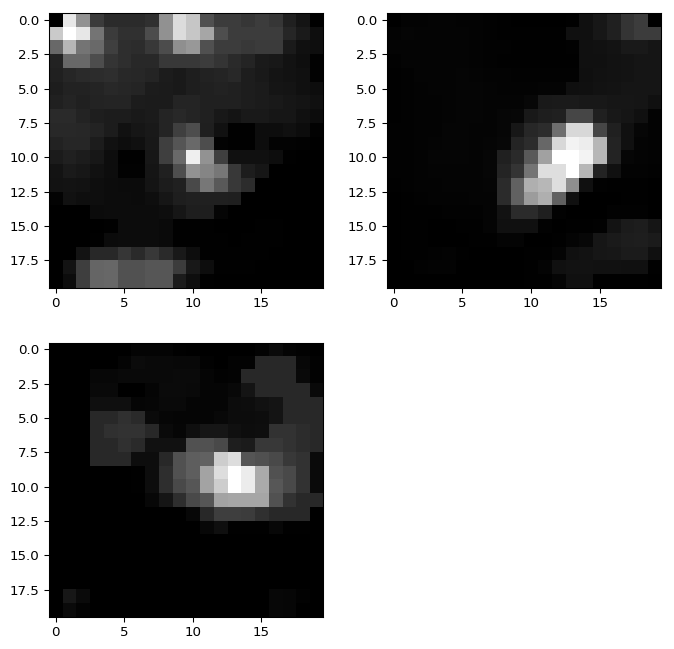

In [20]:
plot_all_transform(clinsig_data,'ktrans', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

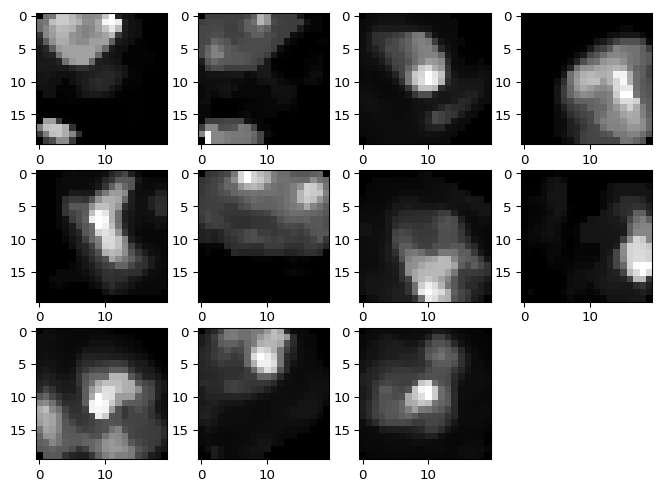

In [21]:
plot_all_transform(not_clinsig_data,'ktrans', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

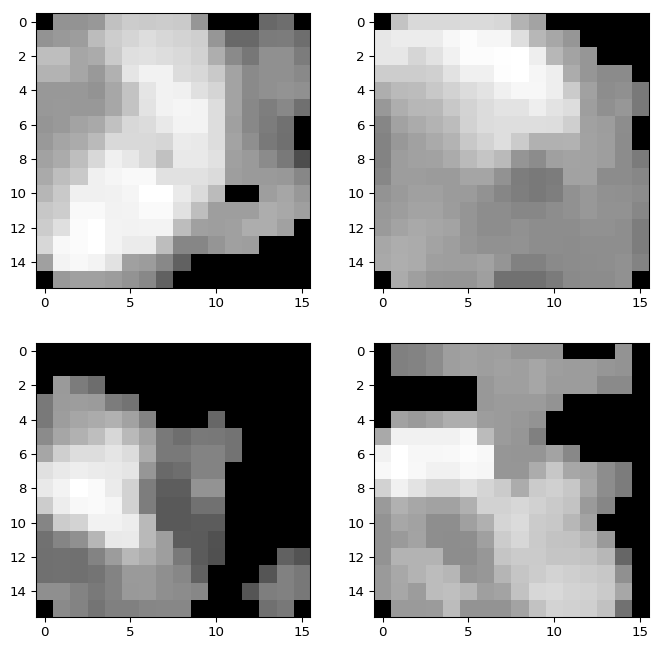

In [22]:
plot_all_transform(clinsig_data,'dwi-adc', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

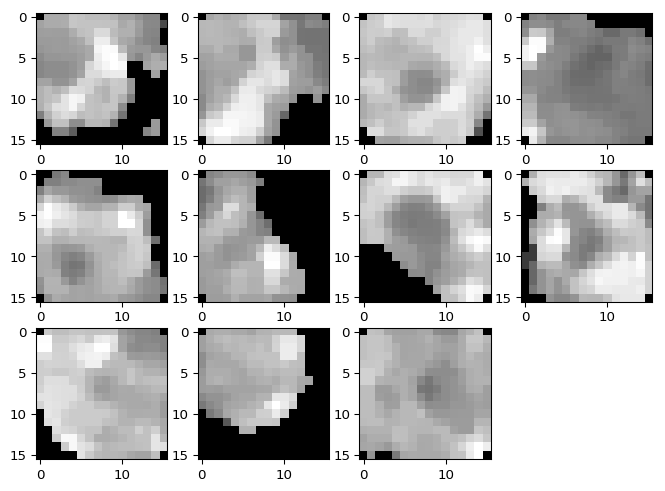

In [23]:
plot_all_transform(not_clinsig_data,'dwi-adc', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

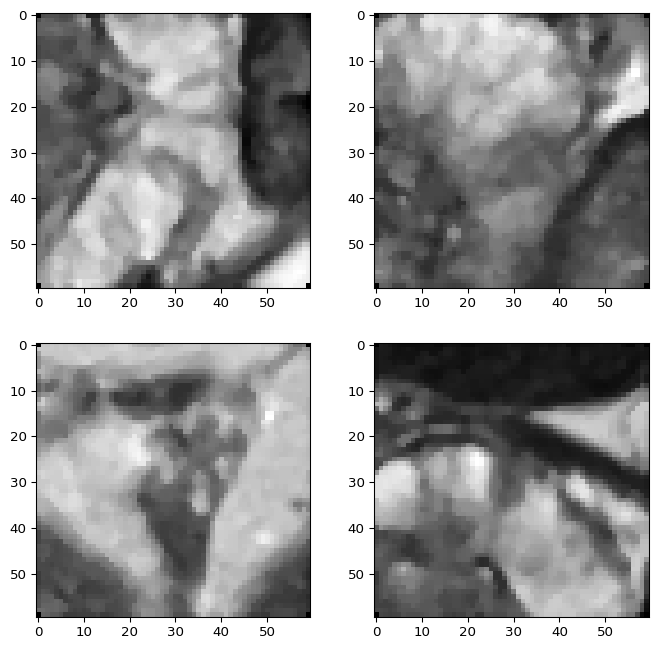

In [24]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

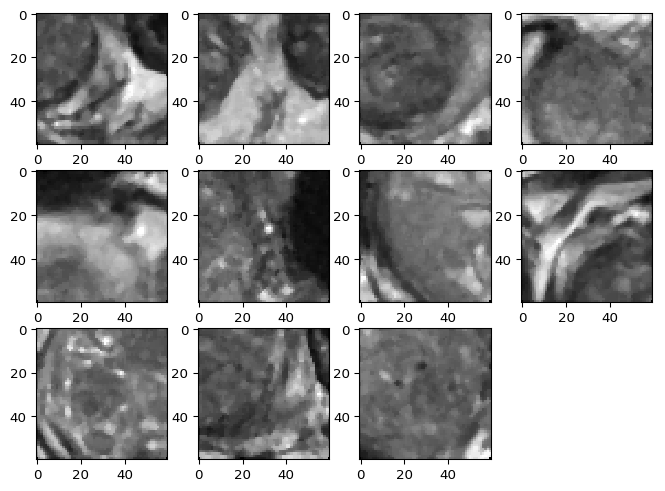

In [25]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: sig.medfilt(roi,kernel_size=[3,3]))

In [26]:
import skimage.filters.rank as rnk
#http://scikit-image.org/docs/dev/api/skimage.filters.rank.html
from skimage.morphology import disk

### MODAL

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


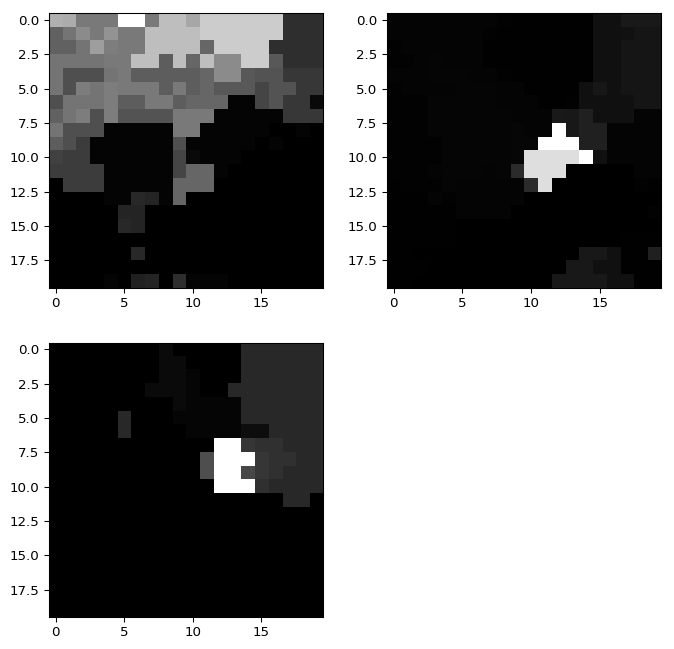

In [27]:
plot_all_transform(clinsig_data,'ktrans', lambda roi: rnk.modal(norm(roi),disk(3)))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


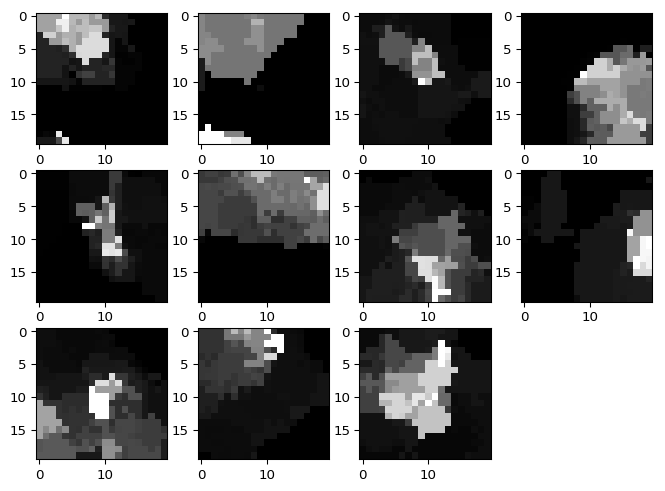

In [28]:
plot_all_transform(not_clinsig_data,'ktrans', lambda roi: rnk.modal(norm(roi),disk(3)))

### ENHANCE_CONTRAST_PERCENTILE

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


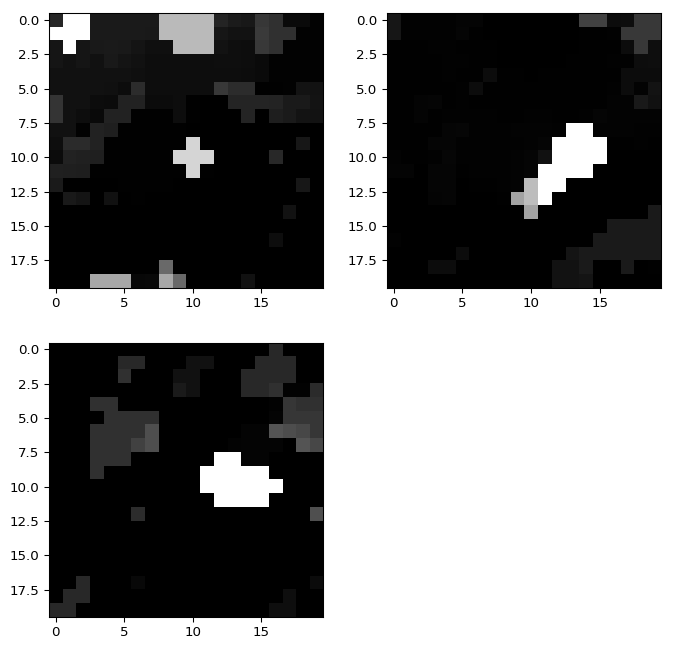

In [29]:
plot_all_transform(clinsig_data,'ktrans', lambda roi: rnk.enhance_contrast_percentile(norm(roi),disk(3)))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


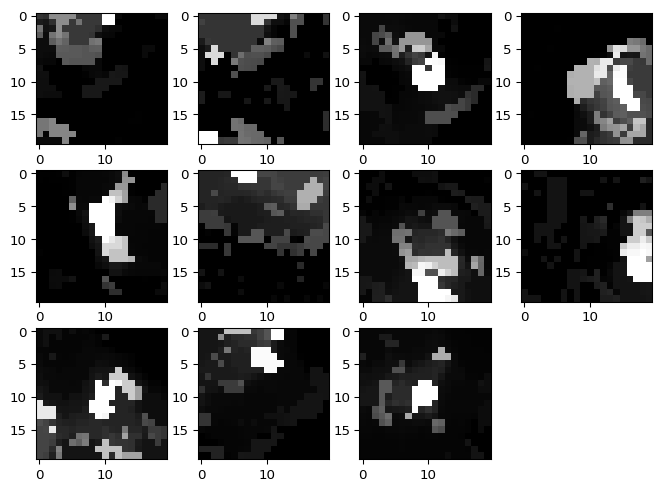

In [30]:
plot_all_transform(not_clinsig_data,'ktrans', lambda roi: rnk.enhance_contrast_percentile(norm(roi),disk(3)))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


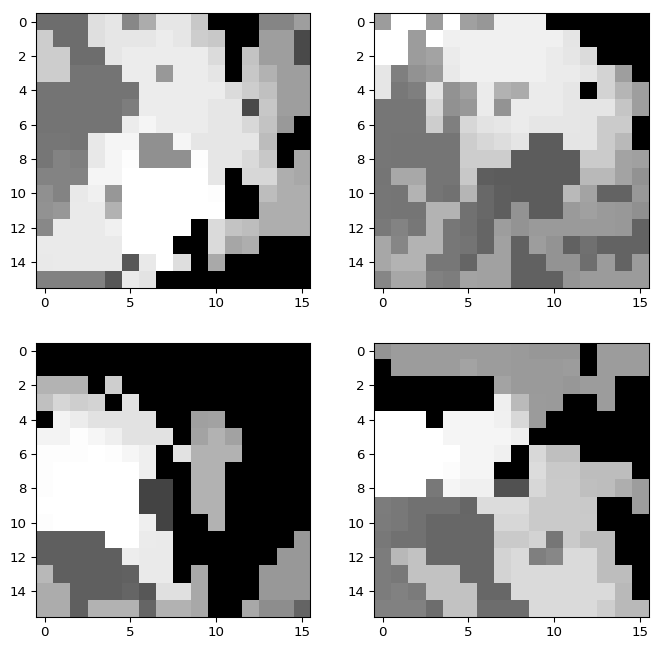

In [31]:
plot_all_transform(clinsig_data,'dwi-adc', lambda roi: rnk.enhance_contrast_percentile(norm(roi),disk(3)))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


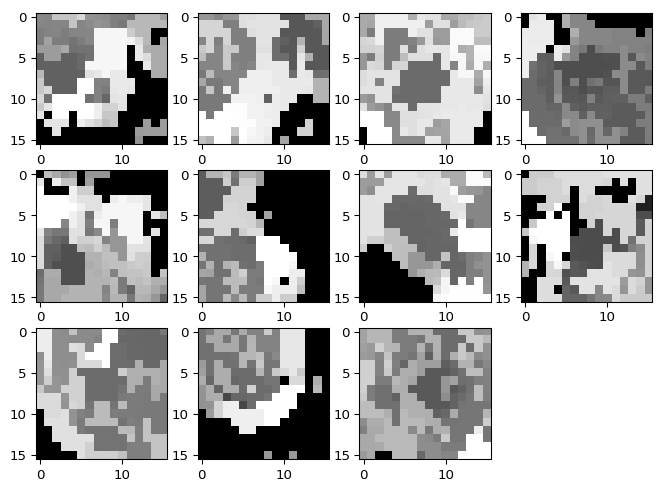

In [32]:
plot_all_transform(not_clinsig_data,'dwi-adc', lambda roi: rnk.enhance_contrast_percentile(norm(roi),disk(3)))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


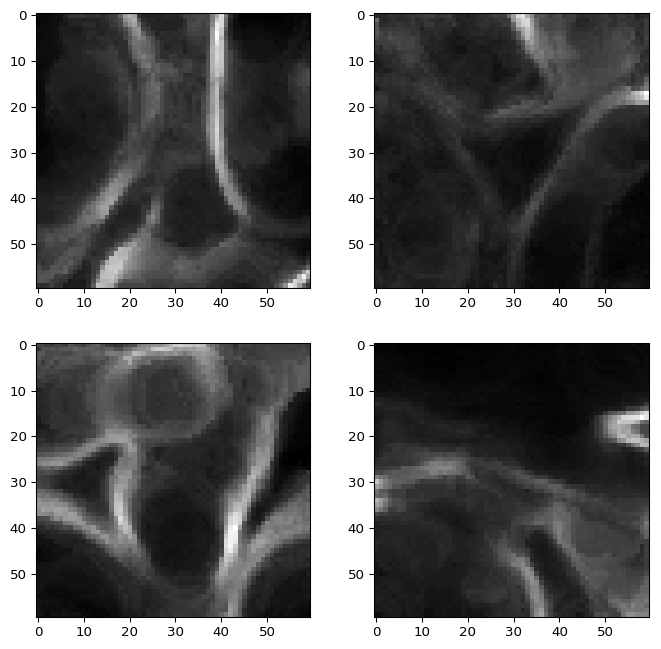

In [33]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(9), p0=0.1, p1=0.25))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


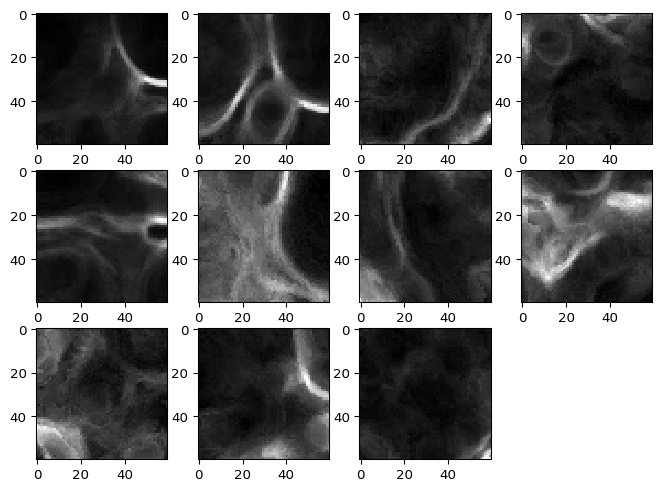

In [34]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(9), p0=0.1, p1=0.25))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


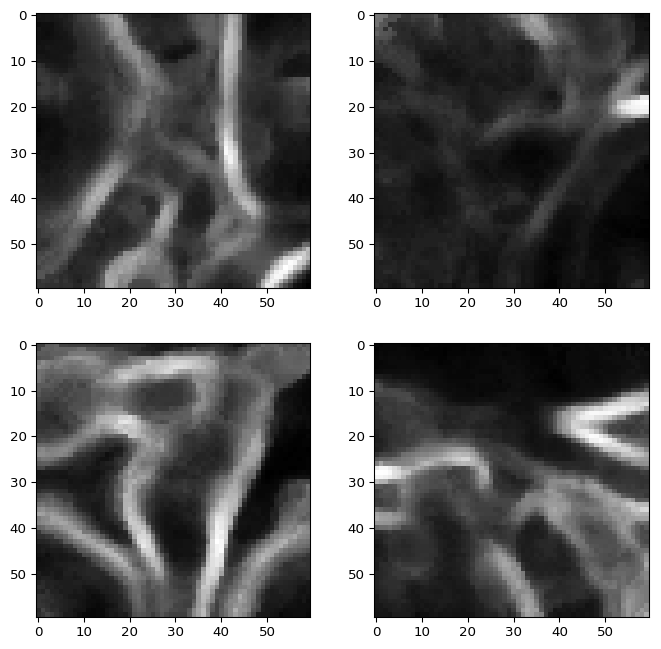

In [35]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(6), p0=0.1, p1=0.5))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


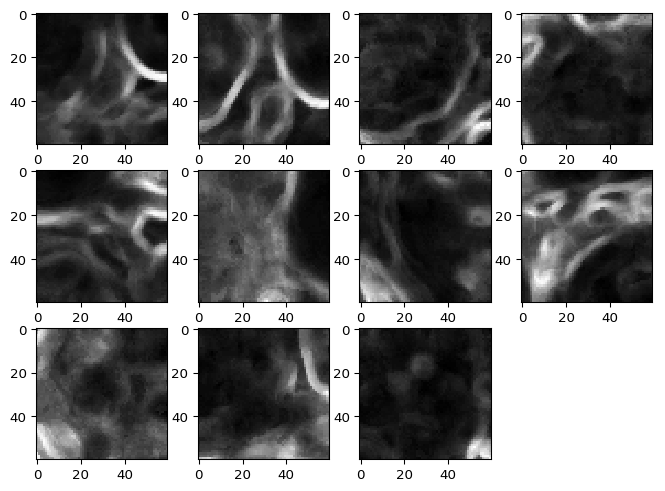

In [36]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(6), p0=0.1, p1=0.5))

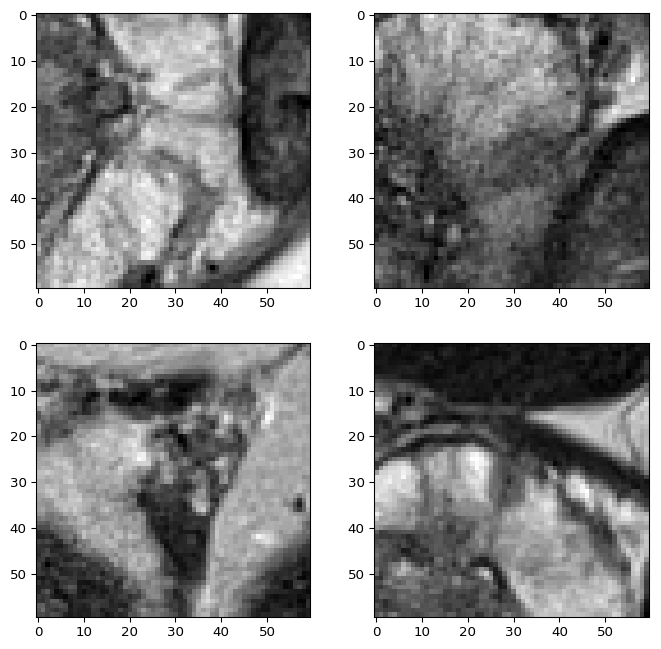

In [37]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: roi)

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


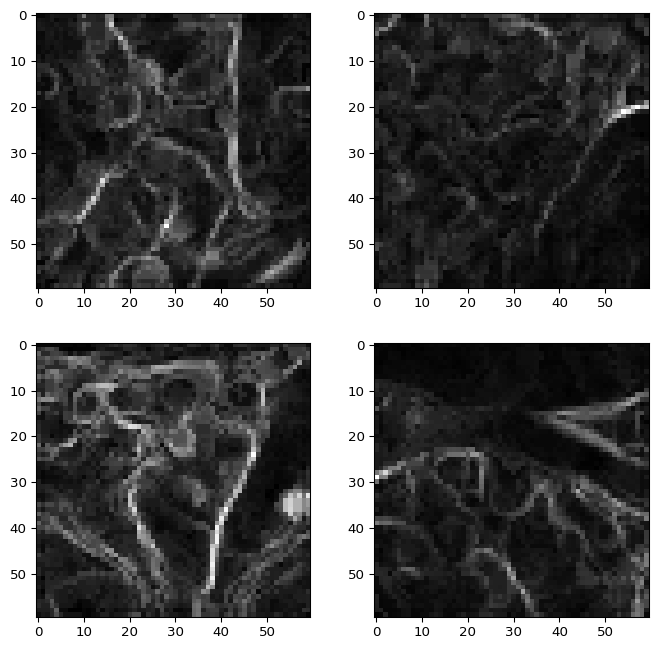

In [38]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(3), p0=0.1, p1=0.25))

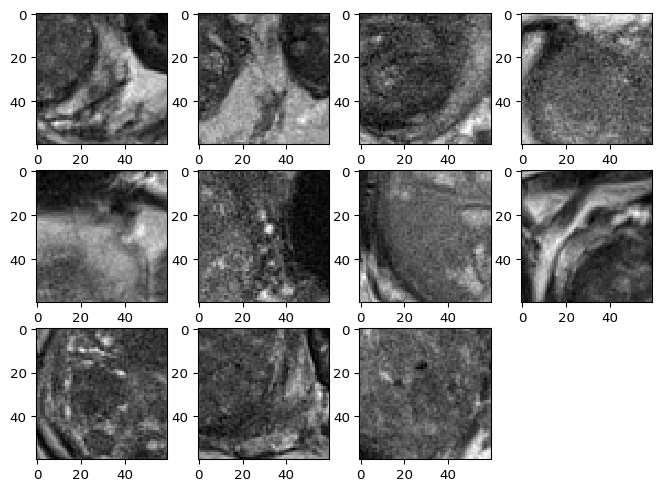

In [39]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: roi)

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


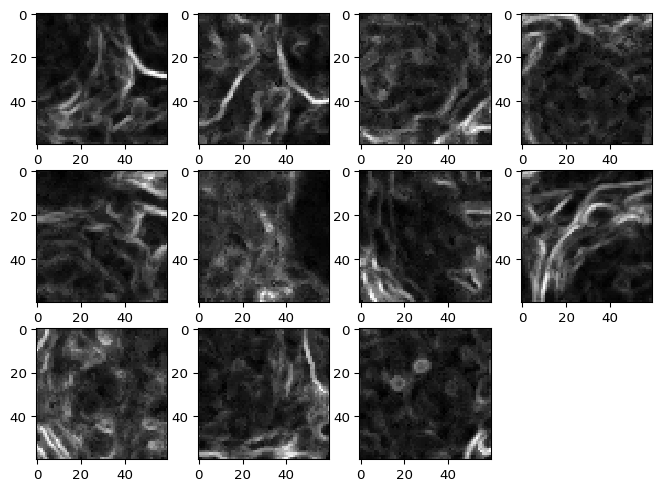

In [40]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(3), p0=0.1, p1=0.5))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


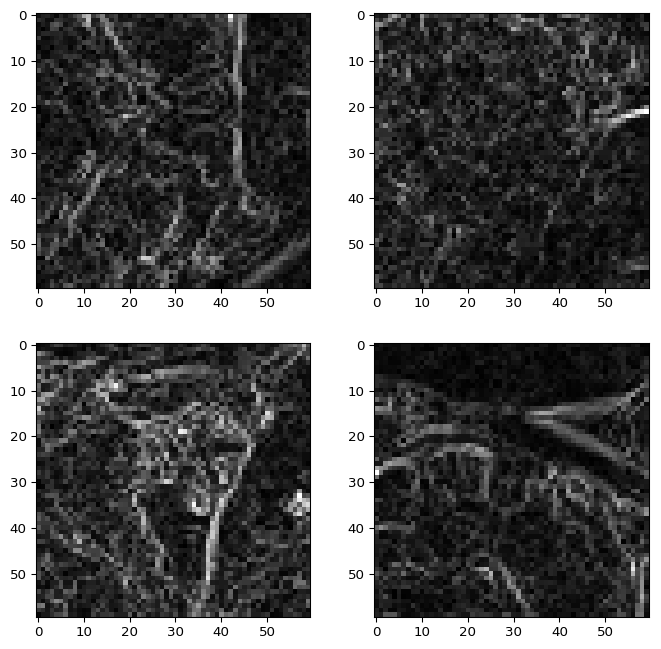

In [41]:
plot_all_transform(clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(1), p0=0.1, p1=0.5))

E:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


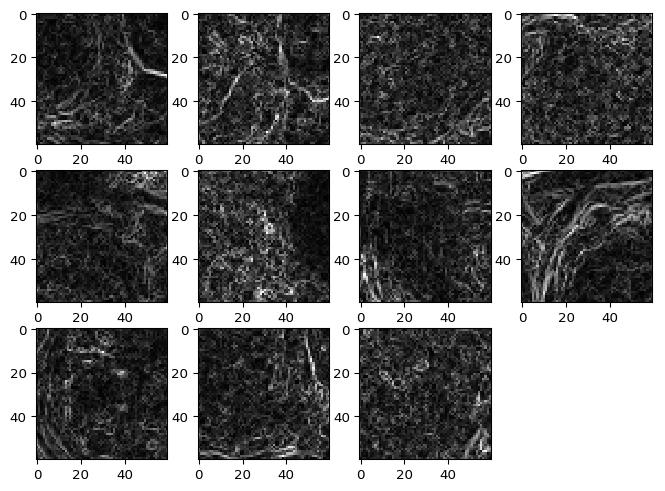

In [42]:
plot_all_transform(not_clinsig_data,'t2-tra', lambda roi: rnk.gradient_percentile(norm(roi),disk(1), p0=0.1, p1=0.5))

In [43]:
import morphsnakes.morphsnakes as morphsnakes

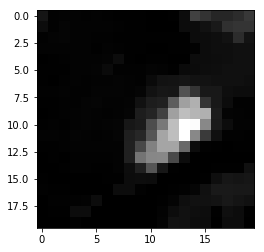

In [44]:
imshow(get_roi(clinsig_data[1],'ktrans',roi_width_mm,0))

In [86]:
import math 
import morphsnakes.morphsnakes as morphsnakes

def segment_ktrans(model, num_iters=15):
    def circle_levelset(shape, center, sqradius, scalerow=1.0):
        """Build a binary function with a circle as the 0.5-levelset."""
        grid = np.mgrid[list(map(slice, shape))].T - center
        phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
        u = np.float_(phi > 0)
        return u

    def roi_lesion_location(img):
        return [math.floor(dim/2) for dim in img.shape]

    ktrans_img = model.images['ktrans']
    roi_ktrans = ktrans_img.imgdata() 
    #get_roi(model,'ktrans',roi_width_mm,roi_depth_mm)
    les_loc = ktrans_img.ijk()# roi_lesion_location(roi_ktrans)
    print(les_loc)
    #roi_ktrans = norm(roi_ktrans)
    msnake = morphsnakes.MorphACWE(roi_ktrans, smoothing=1, lambda1=1, lambda2=3)
    msnake.levelset = circle_levelset(roi_ktrans.shape, les_loc, 3)
    msnake.run(num_iters)
    return msnake.levelset

In [87]:
segment_3d = segment_ktrans(clinsig_data[1], num_iters=15)

[75, 56, 7]


../src\morphsnakes\morphsnakes.py:171: RuntimeWarning: invalid value encountered in double_scalars
  c1 = data[inside].sum() / float(inside.sum())
../src\morphsnakes\morphsnakes.py:180: RuntimeWarning: invalid value encountered in less
  res[aux < 0] = 1
../src\morphsnakes\morphsnakes.py:181: RuntimeWarning: invalid value encountered in greater
  res[aux > 0] = 0


In [88]:
print(segment_3d.shape)

(128, 128, 16)


In [89]:
def plot3d(data):
    plot_all([data[:,:,i] for i in range(data.shape[2])])

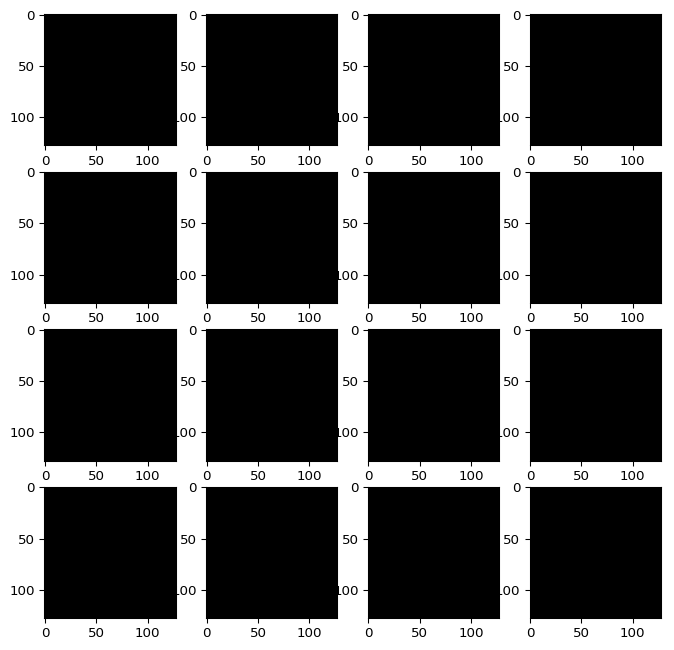

In [90]:
plot3d(segment_3d)

In [ ]:
mlab.contour3d(segment_3d)
mlab.show()

In [ ]:
from matplotlib import pyplot as ppl

roi_ktrans = get_roi(clinsig_data[1],'ktrans',roi_width_mm,roi_depth_mm)[:,:,0]
roi_ktrans = norm(roi_ktrans)

gI = morphsnakes.gborders(roi_ktrans, alpha=1000, sigma=2)
# Morphological GAC. Initialization of the level-set.
mgac = morphsnakes.MorphGAC(gI, smoothing=2, threshold=0.25, balloon=15)
mgac.levelset = circle_levelset(roi_ktrans.shape, roi_lesion_location(roi_ktrans), 2)

# Visual evolution.
ppl.figure()
morphsnakes.evolve_visual(mgac, num_iters=10, background=roi_ktrans)

In [ ]:
from matplotlib import pyplot as ppl

roi_ktrans_3d = get_roi(clinsig_data[1],'ktrans',roi_width_mm,roi_depth_mm)
roi_ktrans_3d = norm(roi_ktrans_3d)
print(roi_ktrans_3d.shape)


# Morphological ACWE. Initialization of the level-set.
macwe = morphsnakes.MorphACWE(roi_ktrans_3d, smoothing=1, lambda1=1, lambda2=2)
macwe.levelset = circle_levelset(roi_ktrans_3d.shape, roi_lesion_location(roi_ktrans_3d), 2)

# Visual evolution.
#morphsnakes.evolve_visual3d(macwe, num_iters=20)